In [1]:
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import ipywidgets as widgets
from IPython.display import display, HTML

import numpy as np
import os

import cv2

from py.helpers import BARRET_ROOT
import os

os.add_dll_directory(r'C:\Program Files\openslide-win64\bin') # for openslide

LANS_DIR = os.path.join(BARRET_ROOT, 'LANS_001-923')
LANS_BIOP_ROOT = os.path.join(BARRET_ROOT, 'p53_experiment_luuk_biopsy-level_no-HE')
LANS_BIOP_DIR = os.path.join(LANS_BIOP_ROOT, 'P53_score_high_consensus')
BIOPSY_DETECT_TEST_DIR = os.path.join(BARRET_ROOT, "Luuk_biopsy-detection", "test_data")

In [3]:
from py.biopsy_detection import get_micron2pixel_fn, get_scanned_areas_from_wsi, get_biopsies_from_scanned_area
from py.biopsy_detect_UI import get_slide_at_idx, get_contoured_img, plot_clean, make_color_by_idx

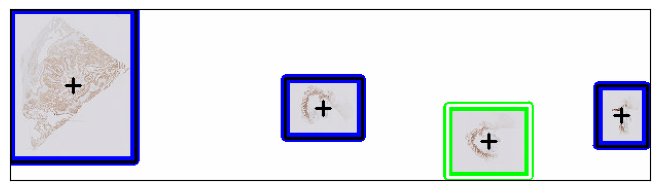

In [4]:
# Plot slide 16
idx = 0
wsi, slidepath = get_slide_at_idx(idx)
spacing = 8
m2p = get_micron2pixel_fn(spacing=spacing)
scanned_areas, img, mask_closed, contours, boxes = get_scanned_areas_from_wsi(wsi, spacing=spacing,
    process_spacing=64)

# plot_clean(img)
# plot_clean(mask_closed, cmap='gray')
plot_clean(get_contoured_img(img.copy(), contours, boxes, 3,
                             color_by_idx={0: {'contour': (0, 255, 0), 'box': (255, 255, 255)}}
                             ))

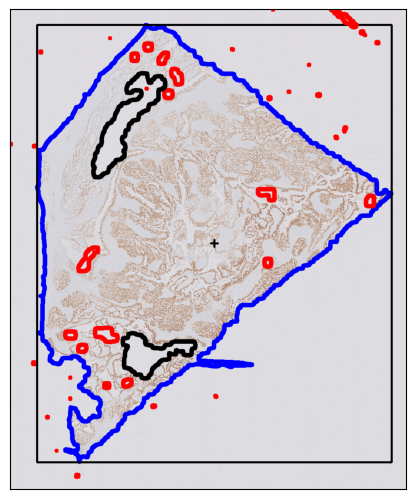

2


In [5]:
scanned_area = scanned_areas[3]
contours, boxes, indices, filtered_indices, mask = get_biopsies_from_scanned_area(scanned_area, m2p)

# not_bg_cont = contours[indices[0]]
not_bg_cont = contours[35]

# plot_clean(patch)
# plot_clean(mask, cmap='gray')
color_by_idx = make_color_by_idx(*filtered_indices)
plot_clean(get_contoured_img(scanned_area.copy(), contours, boxes, 2, color_by_idx=color_by_idx))
empty = np.zeros_like(scanned_area)
contour_idx = 35
empty = cv2.drawContours(empty, [contours[contour_idx]], -1, (0, 0, 255), cv2.FILLED)
print(len(contours[contour_idx]))
# center = np.mean(contours[contour_idx], axis=0).astype(np.int32)
center = contours[contour_idx][0]

2


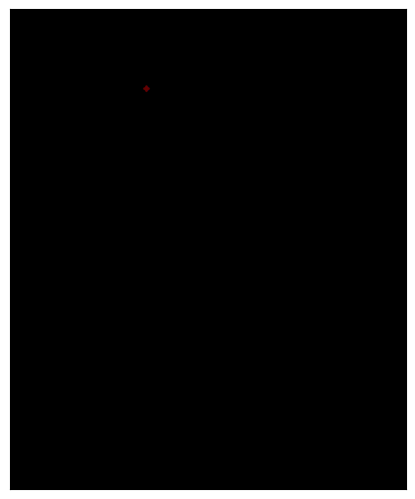

{'inside': nan, 'outside': 1.0}


C:\Users\lverheijen\AppData\Local\Temp\ipykernel_11696\1151600738.py:35: RuntimeWarning: Mean of empty slice.
  bg_tally["inside"] = np.array(bg_tally["inside"]).mean()
c:\Users\lverheijen\AppData\Local\miniconda3\envs\wsi\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
from py.biopsy_detection import get_interpolations

# Plot not_bg_cont on empty np array
array = np.zeros_like(scanned_area)
array = get_contoured_img(array, [not_bg_cont], [(0, 0, 100, 100)], 2)
# Put white cross in center of box
cross_size = 5
center = not_bg_cont.mean(axis=0).astype(np.int32)
point = center
inside_contour = False
ctr = 0 # counter to prevent infinite loop
bg_tally = {"inside":[], "outside":[]}
while not ctr >= len(not_bg_cont):
    # if :
    #     print('Did not find a point inside contour')
    #     break
    inside_contour = cv2.pointPolygonTest(not_bg_cont[:,None,:], (int(point[0]), int(point[1])), False)

    if inside_contour > 0:
        bg_tally["inside"].append(mask[point[1], point[0]])
    else:
        bg_tally["outside"].append(mask[point[1], point[0]])

    color = (0,inside_contour*2+100,0) if inside_contour > 0 else (abs(inside_contour)*2+100,0,0)

    cv2.line(array, (point[0] - cross_size, point[1]), (point[0] + cross_size, point[1]), color, 5)
    cv2.line(array, (point[0], point[1] - cross_size), (point[0], point[1] + cross_size), color, 5)

    # if not inside_contour:
    point = get_interpolations(center, not_bg_cont[ctr], np.random.rand(1).item()*0.75).astype(np.int32)
    ctr += 1
print(ctr)
plot_clean(array)

bg_tally["inside"] = np.array(bg_tally["inside"]).mean()
bg_tally["outside"] = np.array(bg_tally["outside"]).mean()
print(bg_tally)

In [7]:
from xml.etree import ElementTree as ET
from py.xml_utils import prettify, dict_to_xml, xml_to_dict, \
    get_xml_template_dict, AnnotationGroup, map_contour_to_slide_coordinates, \
    add_contour_to_xml_dict

display(get_xml_template_dict())
print(prettify(dict_to_xml(get_xml_template_dict()).getroot()))

{'ASAP_Annotations': {'children': [{'Annotations': {'children': []}},
   {'AnnotationGroups': {'children': [{'Group': {'attrib': {'Name': 'WildType',
         'PartOfGroup': 'None',
         'Color': '#64fe2e'},
        'children': [{'Attibutes': {}}]}},
      {'Group': {'attrib': {'Name': 'OverExpression',
         'PartOfGroup': 'None',
         'Color': '#aaaa00'},
        'children': [{'Attibutes': {}}]}},
      {'Group': {'attrib': {'Name': 'NullMutation',
         'PartOfGroup': 'None',
         'Color': '#0000ff'},
        'children': [{'Attibutes': {}}]}},
      {'Group': {'attrib': {'Name': 'DoubleClones',
         'PartOfGroup': 'None',
         'Color': '#ff0000'},
        'children': [{'Attibutes': {}}]}},
      {'Group': {'attrib': {'Name': 'exclude',
         'PartOfGroup': 'None',
         'Color': '#000000'},
        'children': [{'Attibutes': {}}]}}]}}]}}

<?xml version="1.0" ?>
<ASAP_Annotations>
	<Annotations/>
	<AnnotationGroups>
		<Group Name="WildType" PartOfGroup="None" Color="#64fe2e">
			<Attibutes/>
		</Group>
		<Group Name="OverExpression" PartOfGroup="None" Color="#aaaa00">
			<Attibutes/>
		</Group>
		<Group Name="NullMutation" PartOfGroup="None" Color="#0000ff">
			<Attibutes/>
		</Group>
		<Group Name="DoubleClones" PartOfGroup="None" Color="#ff0000">
			<Attibutes/>
		</Group>
		<Group Name="exclude" PartOfGroup="None" Color="#000000">
			<Attibutes/>
		</Group>
	</AnnotationGroups>
</ASAP_Annotations>



In [8]:
# Read xml like this
path = os.path.join(BARRET_ROOT, "Luuk_biopsy-detection")
xml_path = os.path.join(path, "RBE-00101-P53-I.xml")
# Open xml file
tree = ET.parse(xml_path)
root = tree.getroot()

d = xml_to_dict(tree)
xml = dict_to_xml(d)
display(d)
print(prettify(xml.getroot()))

{'ASAP_Annotations': {'children': [{'Annotations': {'children': [{'Annotation': {'attrib': {'Name': 'Annotation 0',
         'Type': 'Rectangle',
         'PartOfGroup': 'NullMutation',
         'Color': '#000000'},
        'children': [{'Coordinates': {'children': [{'Coordinate': {'attrib': {'Order': '0',
               'X': '112178',
               'Y': '29089'}}},
            {'Coordinate': {'attrib': {'Order': '1',
               'X': '122881',
               'Y': '29089'}}},
            {'Coordinate': {'attrib': {'Order': '2',
               'X': '122881',
               'Y': '22312.0996'}}},
            {'Coordinate': {'attrib': {'Order': '3',
               'X': '112178',
               'Y': '22312.0996'}}}]}}]}},
      {'Annotation': {'attrib': {'Name': 'Annotation 1',
         'Type': 'Rectangle',
         'PartOfGroup': 'NullMutation',
         'Color': '#000000'},
        'children': [{'Coordinates': {'children': [{'Coordinate': {'attrib': {'Order': '0',
               'X': 

<?xml version="1.0" ?>
<ASAP_Annotations>
	<Annotations>
		<Annotation Name="Annotation 0" Type="Rectangle" PartOfGroup="NullMutation" Color="#000000">
			<Coordinates>
				<Coordinate Order="0" X="112178" Y="29089"/>
				<Coordinate Order="1" X="122881" Y="29089"/>
				<Coordinate Order="2" X="122881" Y="22312.0996"/>
				<Coordinate Order="3" X="112178" Y="22312.0996"/>
			</Coordinates>
		</Annotation>
		<Annotation Name="Annotation 1" Type="Rectangle" PartOfGroup="NullMutation" Color="#000000">
			<Coordinates>
				<Coordinate Order="0" X="117733" Y="43265.1016"/>
				<Coordinate Order="1" X="133029" Y="43265.1016"/>
				<Coordinate Order="2" X="133029" Y="32992.3008"/>
				<Coordinate Order="3" X="117733" Y="32992.3008"/>
			</Coordinates>
		</Annotation>
		<Annotation Name="Annotation 2" Type="Rectangle" PartOfGroup="exclude" Color="#000000">
			<Coordinates>
				<Coordinate Order="0" X="27776" Y="48672"/>
				<Coordinate Order="1" X="1984" Y="48672"/>
				<Coordinate Order="2" X

In [9]:
slide_output = widgets.Output()
biopsy_output = widgets.Output()
message_output = widgets.Output()

spacing = 8
process_spacing = 64

# To refresh with new slide
idx = 0
def refresh_slide():
    global idx, slidepath, m2p, scanned_areas, img, area_contours, area_boxes
    wsi, slidepath = get_slide_at_idx(idx)

    if not wsi:
        refresh_slide_idx(1)
        return
    global xml_dict, xml_path
    xml_path = slidepath.replace('.tiff', '.xml')
    xml_dict = None   

    m2p = get_micron2pixel_fn(spacing=spacing)
    scanned_areas, img, mask_closed, area_contours, area_boxes = get_scanned_areas_from_wsi(wsi, spacing=spacing,
        process_spacing=process_spacing, cut_patch_margin=0)
    refresh_area()

def refresh_slide_idx(idx_change=1):
    global idx
    idx += idx_change
    refresh_slide()

open_slide_btn = widgets.Button(description="Open slide outside notebook",
                            layout=widgets.Layout(width='auto', height='auto'))
def open_slide(_):
    global slidepath
    os.startfile(slidepath)
open_slide_btn.on_click(open_slide)

open_folder_btn = widgets.Button(description="Open folder outside notebook",
                            layout=widgets.Layout(width='auto', height='auto'))
def open_folder(_):
    global slidepath
    os.startfile(os.path.dirname(slidepath))
open_folder_btn.on_click(open_folder)

# To refresh with new area
area_idx = 0
def refresh_area(prev_change=1):
    global area_idx, scanned_area, contours, boxes, indices, filtered_indices, mask, area_contours, area_boxes, color_by_idx, slide_output, biopsy_output
    slide_output.clear_output()
    biopsy_output.clear_output()
    
    if area_idx == -1:
        area_idx = len(scanned_areas) - 1
    
    with slide_output:
        # plt.figure(figsize=(10, 2))
        fig, ax = plt.subplots(1, 1, figsize=(15, 2))
        print("Slide index: ", idx)
        plot_clean(get_contoured_img(img.copy(), area_contours, area_boxes, 3,
                                color_by_idx={area_idx: {'contour': (0, 255, 0), 'box': (255, 255, 255)}}
                                ), ax=ax)
        ax.set_title("Wholeslide\n(green = selected area)")
        plt.show()
    scanned_area = scanned_areas[area_idx]
    contours, boxes, indices, filtered_indices, mask = get_biopsies_from_scanned_area(scanned_area, 
                                                            m2p, min_size=300)
    
    if len(indices) == 0:
        refresh_area_idx(prev_change)
        return

    color_by_idx = make_color_by_idx(*filtered_indices)
    refresh_biopsy()

def refresh_area_idx(idx_change=1):
    global idx, area_idx, scanned_areas
    area_idx += idx_change
    if area_idx < 0:
        refresh_slide_idx(-1)
    elif area_idx >= len(scanned_areas):
        area_idx = 0
        refresh_slide_idx(1)
    else:
        refresh_area(prev_change=idx_change)


# To refresh with new biopsy
biopsy_idx = 0
def refresh_biopsy():
    global biopsy_idx, indices, color_by_idx, scanned_area, contours, boxes, mask, biopsy_output
    biopsy_output.clear_output()

    with biopsy_output:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))

        cbi = color_by_idx.copy()
        if len(indices) > 0:
            if biopsy_idx == -1:
                biopsy_idx = len(indices) - 1
            contour_idx = indices[biopsy_idx]
            cbi.update({contour_idx: {'contour': (0, 255, 0), 'box': (0, 0, 0)}})
            # Use numpy to get the bounding box of the contour from the scanned area
            box = boxes[contour_idx] # (x, y, w, h) where (x, y) is the top left corner
            biopsy_img = scanned_area[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
            plot_clean(biopsy_img, ax=ax[1])
            ax[1].set_title("selected biopsy zoomed")

        contoured = get_contoured_img(scanned_area.copy(), contours, boxes, 2, color_by_idx=cbi)
        # Place scanned_area and contoured next to each other in the first subplot using np.concatenate, with a black line in between
        show_mask = np.stack([mask, mask, mask], axis=2) * 255
        grid = np.concatenate((scanned_area, np.zeros((scanned_area.shape[0], 3, 3), dtype=np.uint8), 
                               show_mask, np.zeros((scanned_area.shape[0], 3, 3), dtype=np.uint8),
                               contoured), axis=1)
        plot_clean(grid, ax=ax[0])
        ax[0].set_title(f"area index: {area_idx}\nselected biopsy index: {biopsy_idx}\nscan  |  mask  |  contours")
        plt.show()

    global xml_dict, xml_path
    message_output.clear_output()
    with message_output:
        if os.path.exists(xml_path) and not xml_dict:
            display(HTML('<p style="color: red;">XML file exists, clicking "not biopsy" or "confirm biopsy" will overwrite it.</p>'))

def refresh_biopsy_idx(idx_change=1):
    global biopsy_idx, area_idx, indices
    biopsy_idx += idx_change
    if biopsy_idx < 0:
        refresh_area_idx(-1)
    elif biopsy_idx >= len(indices):
        biopsy_idx = 0
        refresh_area_idx(1)
    else:
        refresh_biopsy()


next_btn = widgets.Button(description="Next biopsy  >")
next_btn.on_click(lambda _: refresh_biopsy_idx(1))
prev_btn = widgets.Button(description="<  Previous biopsy")
prev_btn.on_click(lambda _: refresh_biopsy_idx(-1))

go_to_idx = widgets.IntText(value=0, description='Go to slide index:', layout=widgets.Layout(width='auto', height='auto'))
def go_to_idx_changed(change):
    if change['name'] != 'value':
        return
    global idx, area_idx, biopsy_idx
    idx = change['new']
    area_idx = 0
    biopsy_idx = 0
    refresh_slide()
go_to_idx.observe(go_to_idx_changed)


def save_annotation(is_biopsy):
    global xml_dict, xml_path, biopsy_idx, area_idx, area_boxes, indices
    if not xml_dict and (biopsy_idx > 0 or area_idx > 0):
        with message_output:
            display(HTML(f'<p style="color: orange;">Please start from biopsy and area index 0. (You are currently at biopsy index {biopsy_idx} and area index {area_idx}, click "< Previous biopsy" until you are at 0)</p>'))
        return
    mapped_contour = map_contour_to_slide_coordinates(contours[indices[biopsy_idx]], spacing, process_spacing, area_boxes[area_idx])
    group = "None" if is_biopsy else AnnotationGroup.EXCLUDE
    xml_dict = add_contour_to_xml_dict(xml_dict, mapped_contour, annotation_group=group)
    dict_to_xml(xml_dict).write(xml_path)
    refresh_biopsy_idx(1)


not_biopsy_btn = widgets.Button(description="Not biopsy")
not_biopsy_btn.on_click(lambda _: save_annotation(False))
yes_biopsy_btn = widgets.Button(description="Confirm biopsy")
yes_biopsy_btn.on_click(lambda _: save_annotation(True))

# Display
display(go_to_idx)
display(widgets.HBox([slide_output, open_slide_btn, open_folder_btn]))
display(widgets.HBox([prev_btn, not_biopsy_btn, yes_biopsy_btn, next_btn]), message_output, biopsy_output)
refresh_slide()

IntText(value=0, description='Go to slide index:', layout=Layout(height='auto', width='auto'))

Output()

Output()

In [ ]:
def split_contour(c, size_threshold, distance_threshold=30, skip_if_large=1e5):
    """Split a contour into two contours on a thin bottleneck, if the two resulting contours are both larger than the size threshold"""
    # Return the contour if it is smaller than double the size threshold
    area = cv2.contourArea(c)
    if area < size_threshold * 2:
        return [c]
    elif area > skip_if_large:
        return [c]

    # Get the points of the contour
    points = c[:, 0, :]

    # Create pairwise distances between all points
    distances = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)

    # We want to find a thin bottleneck in the contour, so we want to find pairs that are close together
    close_pairs = np.argwhere((distances < distance_threshold) & (distances > 0))

    # Get the unique pairs
    unique_pairs = np.unique(np.sort(close_pairs, axis=-1), axis=0)

    # Sort the pairs by distance
    unique_pairs = unique_pairs[np.argsort(distances[unique_pairs[:, 0], unique_pairs[:, 1]])]

    # For each pair, get the contour points between the two points
    # If the resulting contours are larger than the size threshold, return the two resulting contours
    # Otherwise, return the original contour

    # Get the points between the two points
    def get_points_between(p1, p2):
        # Get the indices of the points between the two points
        indices = np.arange(p1, p2)
        # Get the points between the two points
        return points[indices]
    
    # Get the two resulting contours
    def get_resulting_contours(p1, p2):
        # Get the points between the two points
        points_between = get_points_between(p1, p2)
        # Get the contour between the two points
        contour_between = points_between[:, None, :]
        # Get the contour outside the two points
        contour_outside = np.concatenate([points[:p1, None, :], points[p2:, None, :]], axis=0)
        return contour_between, contour_outside
    
    # Get the two resulting areas
    def get_resulting_areas(p1, p2):
        contour_between, contour_outside = get_resulting_contours(p1, p2)
        return cv2.contourArea(contour_between), cv2.contourArea(contour_outside)
    
    # Check for each pair if the resulting contours are larger than the size threshold
    # If they are, return the two resulting contours
    # Otherwise, return the original contour
    for p1, p2 in unique_pairs:
        area_between, area_outside = get_resulting_areas(p1, p2)
        if area_between < size_threshold or area_outside < size_threshold:
            continue
        # If the center of one is inside the other, we don't want to split it
        # Get the center of the two areas
        contour_between, contour_outside = get_resulting_contours(p1, p2)
        center_between = contour_between.mean(axis=0)
        center_outside = contour_outside.mean(axis=0)
        # Check if the center of one is inside the other
        if cv2.pointPolygonTest(contour_between, tuple(center_outside[0]), False) >= 0:
            continue
        if cv2.pointPolygonTest(contour_outside, tuple(center_between[0]), False) >= 0:
            continue 
        return get_resulting_contours(p1, p2)
    return [c]

In [ ]:
spacing = 64.0 # microns per pixel

# Get first .tiff file in directory
files = os.listdir(LANS_BIOP_DIR)
files = [f for f in files if f.endswith('.tiff')]

for file_nr, file in enumerate(files[:]):
    file_path = os.path.join(LANS_BIOP_DIR, file)

    # Read the wsi
    try:
        wsi = WholeSlideImage(file_path)
        print(f"{file_nr}/{len(files)}: {file_path}")
    except:
        print(f"Could not read {file_path}")
        continue
    image = wsi.get_slide(spacing=spacing)

    # Null background is usually 254,254,254 or 254,0,0
    # Scanned background is usually around 225,225,225, we want to keep this, so we exclude it from the mask
    mask = get_most_common_mask(image, similarity=30, exclude=np.array([225, 225, 225]), only_edge=True)

    # Make a copy of the image as a UMat object
    image_um = cv2.UMat(image)

    # Get contours of the mask
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out the small contours
    contours = [c for c in contours if cv2.contourArea(c) > 1000]

    # Get bounding boxes for the contours
    boxes = [cv2.boundingRect(c) for c in contours]

    # Filter out boxes that have a much larger area than the contour (the contour is not close to a rectangle)
    boxes = [box for box, contour in zip(boxes, contours) if cv2.contourArea(contour) / (box[2] * box[3]) > 0.9]

    # Draw purple cross on the image at the center of each bounding box
    for x, y, w, h in boxes:
        cv2.line(image_um, (x + w // 2 - 10, y + h // 2), (x + w // 2 + 10, y + h // 2), (255, 0, 255), 2)
        cv2.line(image_um, (x + w // 2, y + h // 2 - 10), (x + w // 2, y + h // 2 + 10), (255, 0, 255), 2)

    # Draw bounding boxes on the image
    for x, y, w, h in boxes:
        cv2.rectangle(image_um, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the mask on top of the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(image_um.get())
    plt.show()

    # Adjust boxes for spacing
    boxes = [(x, y, w, h) for x, y, w, h in boxes]
    boxes = [(x * spacing*4, y * spacing*4, w*spacing, h*spacing) for x, y, w, h in boxes]

    # Take 2% off each side of the box
    boxes = [(x + w * 0.02, y + h * 0.02, w * 0.96, h * 0.96) for x, y, w, h in boxes]

    # Get patch of each box from the wsi
    new_spacing = 8.0
    patches = [wsi.get_patch(x, y, w/new_spacing, h/new_spacing, spacing=new_spacing, center=False) for x, y, w, h in boxes]

    # Display the patches in a horizontal row
    plt.figure(figsize=(5*len(patches), 5))
    for i, patch in enumerate(patches):
        mask = get_most_common_mask(patch, similarity=10)
        patch = patch.astype(np.uint8)
        show_img = patch.copy()

        # Opening and closing without changing to UMat
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

        # Make contours
        # A contour is a 3D array of points, these represent the points on the contour. 
        # The first dimension is the index of the point, the second is the index of the contour, and the third is the x and y coordinates of the point.
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # Make mask 3 channels 0-255
        show_mask = np.stack([mask, mask, mask], axis=-1).astype(np.uint8) * 255

        # Filter out contours that are dark, or small
        size_threshold = (8/new_spacing)**2 * 7500
        new_contours = []
        for c in contours:
            if cv2.contourArea(c) < size_threshold:
                cv2.drawContours(show_mask, [c], 0, (255, 0, 0), 5)
                continue
            # If area of bounding box is almost the area of the patch
            x, y, w, h = cv2.boundingRect(c)
            if w * h > 0.9 * patch.shape[0] * patch.shape[1]:
                cv2.drawContours(show_mask, [c], 0, (255, 0, 255), 5)
                continue
            # If contour hits the edge of the patch
            edge_hits = [p for p in c[:, 0, :] if p[0] == 0 or p[0] == mask.shape[1]-1 or p[1] == 0 or p[1] == mask.shape[0]-1]
            for hit in edge_hits:
                # Draw a blue dot on the image at the edge hit
                cv2.circle(show_mask, tuple(hit), 50, (255, 255, 0), 50)
            edge_hits = len(edge_hits)
            if edge_hits > 2:
                cv2.drawContours(show_mask, [c], 0, (255, 255, 0), 5)
                cv2.putText(show_mask, f"hits: {edge_hits}", tuple(c[0, 0, :]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 5)
                continue
            if not get_contour_inner(mask, c[:,0,:], factor=0.9):
                cv2.drawContours(show_mask, [c], 0, (0, 255, 0), 5)
                cv2.putText(show_mask, "outer", tuple(c[0, 0, :]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 5)
                continue

            # Draw contour on the image
            cv2.drawContours(show_img, [c], 0, (0, 0, 0), 5)
            new_contours.append(c)
        contours = new_contours

        # Get bounding boxes for the contours
        boxes = [cv2.boundingRect(c) for c in contours]

        # Filter out boxes that have their center in another bounding box
        def box_center_in_box(box1, box2):
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            return x1 + w1 // 2 > x2 and x1 + w1 // 2 < x2 + w2 and y1 + h1 // 2 > y2 and y1 + h1 // 2 < y2 + h2
        
        box_indices = [j for j, box1 in enumerate(boxes) if not any([box_center_in_box(box1, box2) for box2 in boxes if box1 != box2])]
        boxes = [boxes[j] for j in box_indices]
        contours = [contours[j] for j in box_indices]

        new_contours = []
        for c in contours:
            new_contours.extend(split_contour(c, size_threshold*3, distance_threshold=30, skip_if_large=2e5))


        # Draw contours and bounding boxes on the image
        for j in range(len(new_contours)):
            contour = new_contours[j]
            x, y, w, h = cv2.boundingRect(contour)
            center = (x + w // 2, y + h // 2)

            # Draw blue contour on the image
            contour_color = (0, 0, 255)
            cv2.drawContours(show_img, [contour], 0, contour_color, 5)
            # Draw green bounding box on the image
            cv2.rectangle(show_img, (x, y), (x + w, y + h), (0, 255, 0), 5)


            # Show the area of the contour in the top left corner
            area = cv2.contourArea(contour)
            cv2.putText(show_img, f"{area:.0f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 5)

            # If the area is too large, draw large red cross through the bounding box
            if area > 2e5:
                cv2.line(show_img, (x, y), (x + w, y + h), (255, 0, 0), 5)
                cv2.line(show_img, (x + w, y), (x, y + h), (255, 0, 0), 5)
            else:
                # Draw large purple cross on the image at the center of each bounding box
                cv2.line(show_img, (x + w // 2 - 10, y + h // 2), (x + w // 2 + 10, y + h // 2), (0, 255, 0), 5)
                cv2.line(show_img, (x + w // 2, y + h // 2 - 10), (x + w // 2, y + h // 2 + 10), (0, 255, 0), 5)

        plt.subplot(3, len(patches), i + 1)
        plt.imshow(patch)
        plt.subplot(3, len(patches), i + 1 + len(patches))
        plt.imshow(show_mask)
        plt.subplot(3, len(patches), i + 1 + len(patches)*2)
        plt.imshow(show_img)

    # Make one legend for all axes, outside last plot
    plt.subplot(3, len(patches), i+1+len(patches))
    plt.legend(handles=[
        plt.Rectangle((0, 0), 1, 1, color=(0, 0, 0)),
        mpatches.Circle((0, 0), 0.25, edgecolor=(1, 0, 0), facecolor="none", linewidth=2),
        mpatches.Circle((0, 0), 0.25, edgecolor=(1, 0, 1), facecolor="none", linewidth=2),
        mpatches.Circle((0, 0), 0.25, edgecolor=(1, 1, 0), facecolor="none", linewidth=2),
        mpatches.Circle((0, 0), 0.25, edgecolor=(0, 1, 0), facecolor="none", linewidth=2)], labels=[
            'Background',
            'Too small', 
            'Stretches across entire patch', 
            'Edge hit',
            'Surrounds background area',
            ], loc='upper left', bbox_to_anchor=(1, 1))

    # Make one legend for all axes, outside last plot
    plt.subplot(3, len(patches), i+1+len(patches)*2)
    plt.legend(handles=[
        mpatches.Circle((0.5, 0.5), 0.25, edgecolor=(0,0,0), facecolor="none", linewidth=2), 
        mpatches.Circle((0.5, 0.5), 0.25, edgecolor=(0,0,1), facecolor="none", linewidth=2), 
        mpatches.Circle((0.5, 0.5), 0.25, edgecolor=(0,1,0), facecolor="none", linewidth=2), 
        mlines.Line2D([], [], color=(0,1,0), marker='+', linestyle='None', markersize=10, markeredgewidth=1),
        mlines.Line2D([], [], color=(1,0,0), marker='X', linestyle='None', markersize=10, markeredgewidth=1)
    ], labels=[
        'Inside another box',
        'Detected tissue',
        'Detected biopsy',
        'Center of biopsy',
        'Large area'
    ], loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()

    # Nr 45 has limited magnification
